In [29]:
import numpy as np
import tensorflow as tf
import pandas as pd

In [30]:
%run trainingUtils.ipynb
%run utils.ipynb

In [31]:
csv_fp='image_labels.csv'

# Data Preprocessing

In [32]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness
    mean = tf.reduce_mean(image)
    std = tf.math.reduce_std(image)
    image = (image - mean) / std
    return image


In [33]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)  # Randomly flip images horizontally
    image = tf.image.random_flip_up_down(image)     # Randomly flip images vertically
    image = tf.image.random_brightness(image, max_delta=0.1)  # Randomly adjust brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Randomly adjust contrast
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)  # Randomly adjust saturation
    image = tf.image.random_hue(image, max_delta=0.02)  # Randomly adjust hue
    return image


In [34]:
def preprocess_and_augment(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0  # Normalize to [0, 1]
    image = augment_image(image)  # Apply data augmentation
    return image

# Load data and preprocess images

In [35]:
def load_data():
    data = pd.read_csv(csv_fp)
    
    # Preprocess images and load labels
    images = [preprocess_image(path) for path in data['file_path']]
    labels = data['is_sepia'].values
    images = np.stack([preprocess_and_augment(path) for path in data['file_path']], axis=0)
    labels = data['is_sepia'].values.astype(np.float32)

    return images, labels
    return np.array(images), np.array(labels)

In [36]:
inputs,outputs=load_data()
print(inputs[0:3])
print(outputs[0:3])

[[[[-0.09001578 -0.09001578 -0.09001578]
   [-0.09001578 -0.09001578 -0.09001578]
   [-0.09001578 -0.09001578 -0.09001578]
   ...
   [-0.09001578 -0.09001578 -0.09001578]
   [-0.09001578 -0.09001578 -0.09001578]
   [-0.09001578 -0.09001578 -0.09001578]]

  [[-0.09001578 -0.09001578 -0.09001578]
   [-0.09001578 -0.09001578 -0.09001578]
   [-0.09001578 -0.09001578 -0.09001578]
   ...
   [-0.09001578 -0.09001578 -0.09001578]
   [-0.09001578 -0.09001578 -0.09001578]
   [-0.09001578 -0.09001578 -0.09001578]]

  [[-0.09001578 -0.09001578 -0.09001578]
   [-0.09001578 -0.09001578 -0.09001578]
   [-0.09001578 -0.09001578 -0.09001578]
   ...
   [-0.09001578 -0.09001578 -0.09001578]
   [-0.09001578 -0.09001578 -0.09001578]
   [-0.09001578 -0.09001578 -0.09001578]]

  ...

  [[-0.09001578 -0.09001578 -0.09001578]
   [-0.09001578 -0.09001578 -0.09001578]
   [-0.09001578 -0.09001578 -0.09001578]
   ...
   [-0.09001578 -0.09001578 -0.09001578]
   [-0.09001578 -0.09001578 -0.09001578]
   [-0.09001578 

In [37]:
train_inputs, train_outputs, test_inputs,test_outputs = splitData(inputs, outputs)
print(len(train_inputs))
print(train_inputs[0])
print(train_outputs)


72
[[[0.918941   0.8276547  0.6582245 ]
  [0.9336533  0.83921593 0.679635  ]
  [1.0329262  0.9447035  0.7463737 ]
  ...
  [1.0883889  1.0827347  0.8758908 ]
  [1.0879552  1.0817981  0.8725397 ]
  [1.068009   1.0349282  0.83408535]]

 [[0.9711654  0.87987906 0.71044886]
  [0.89266545 0.7982281  0.63864714]
  [1.0279897  0.939767   0.7414372 ]
  ...
  [1.0813235  1.0883889  0.86766565]
  [1.0802647  1.0736061  0.8631314 ]
  [1.0861932  1.0741004  0.8652193 ]]

 [[1.0777848  0.98277354 0.8032887 ]
  [1.0245334  0.9276464  0.74986726]
  [1.0478525  0.9522859  0.7718258 ]
  ...
  [1.0846322  1.0861424  0.8657088 ]
  [1.0715371  1.069511   0.852294  ]
  [1.0839523  1.0819261  0.86470926]]

 ...

 [[1.0835615  1.0738989  0.86494815]
  [1.0586319  1.0255512  0.8247083 ]
  [1.0846469  1.033564   0.84020865]
  ...
  [1.0689776  0.99244046 0.7978848 ]
  [1.0786153  1.0020782  0.80752254]
  [1.0868487  1.0132672  0.8186265 ]]

 [[1.0838279  1.0777478  0.8569296 ]
  [1.0860006  1.066806   0.8544112

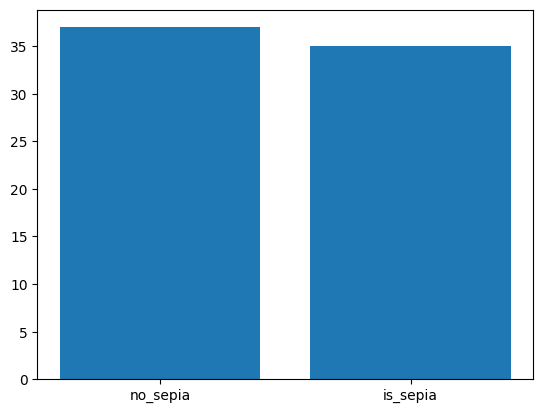

In [38]:
plotTrainingDataDistribution(train_inputs,train_outputs,['is_sepia'],['no_sepia','is_sepia'])

In [39]:
# plotDataDistribution(inputs,outputs,['no_sepia','is_sepia'],'Sepia Dataset')

In [40]:
def evaluate_model(train_inputs,train_outputs,test_inputs,test_outputs,predictedLabels):
    # print(test_outputs)
    # print(predictedLabels)
    acc,precision,recall,confMatrix=evalMultiClass(np.array(test_outputs),predictedLabels,['no_sepia','sepia'])
    # acc,precision,recall,confMatrix=evaluate(test_outputs, predictedLabels, ['no_sepia','sepia'])
    # print('Confusion Matrix: ',confMatrix)
    plotConfusionMatrix(confMatrix,['no_sepia','sepia'],'Sepia Dataset')
    print('Accuracy: ',acc)
    print('Precision: ',precision)
    print('Recall: ',recall)
    plotImagesAndPredictions(test_inputs, test_outputs, predictedLabels,n=int(np.round(len(test_outputs)/3)),m=3,figsize=(10,10))

In [41]:
#with ann tool


In [42]:
%run ToolANN.ipynb

In [43]:
print('With ANN Tool')

With ANN Tool


In [44]:
predictedLabels=with_ANNTool(train_inputs,train_outputs,test_inputs,test_outputs)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step - accuracy: 1.0000 - loss: 0.2285
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 1.2598e-34
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━

In [45]:
resultsTuning=run_hyperparameter_testing_ANN(train_inputs, train_outputs, test_inputs, test_outputs)
print(resultsTuning)

Training with config: {'epochs': 50, 'activation': 'relu', 'loss': 'binary_crossentropy', 'optimizer': 'adam'}
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4831 - loss: 3.2703 
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5638 - loss: 4.6483
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5009 - loss: 8.1997
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5343 - loss: 3.2140
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5304 - loss: 1.3844
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6003 - loss: 1.1462
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6389 - loss: 1.0189
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5117 - loss: 1.0988
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6055 - loss: 0.9297
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5521 - loss: 1.3497
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accur

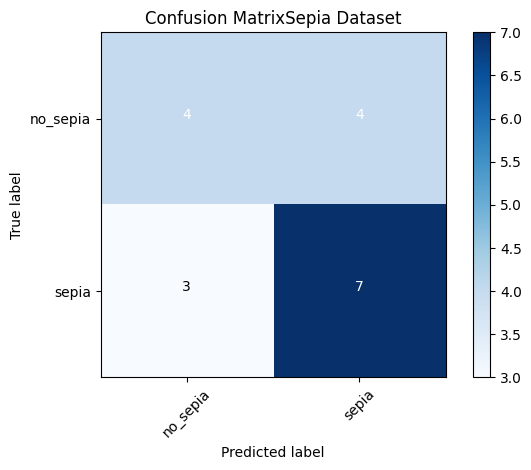

Accuracy:  0.6111111111111112
Precision:  {'no_sepia': 0.5714285714285714, 'sepia': 0.6363636363636364}
Recall:  {'no_sepia': 0.5, 'sepia': 0.7}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

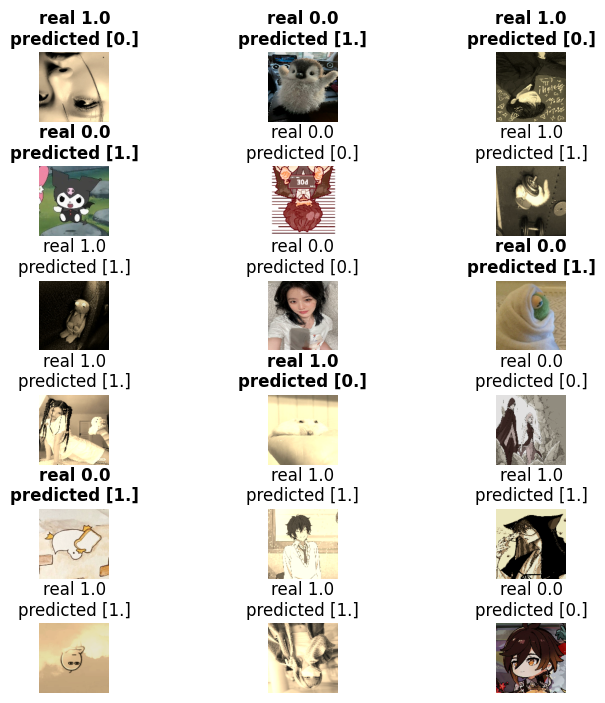

In [46]:
evaluate_model(train_inputs,train_outputs,test_inputs,test_outputs,predictedLabels)


In [47]:
print('With CNN Tool')

With CNN Tool


In [48]:
%run CNN.ipynb

In [49]:
predictedLabels=with_CNN(train_inputs,train_outputs,test_inputs,test_outputs)


Epoch 1/40


C:\Users\Deea\Desktop\Uni\By Year\Second year\Semester 2\AI\Laboratories\Laboratory_8\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5560 - loss: 2.8463
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4757 - loss: 1.5788
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5343 - loss: 0.6698
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5760 - loss: 0.5884
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7444 - loss: 0.5549
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7747 - loss: 0.4229
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8780 - loss: 0.3201
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8433 - loss: 0.3363
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6228 - loss: 0.9955
Epoch 10/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7847 - loss: 0.4291
Epoch 11/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7374 - loss: 0.3997
Epoch 12/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8928 - loss: 0.3623
Epoch 13/40


In [50]:
run_cnn_experiments(train_inputs, train_outputs, test_inputs, test_outputs)

Training with config: {'epochs': 20, 'batch_size': 16, 'learning_rate': 0.001}
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5411 - loss: 1.3451
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4505 - loss: 0.6904
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7425 - loss: 0.5959
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6450 - loss: 0.5609
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9005 - loss: 0.3359
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7419 - loss: 0.5302
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7399 - loss: 0.4356
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9248 - loss: 0.2689
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9346 - loss: 0.1961
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9734 - loss: 0.1150
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0918
Epoch 

[({'epochs': 20, 'batch_size': 16, 'learning_rate': 0.001},
  0.8888888888888888),
 ({'epochs': 30, 'batch_size': 32, 'learning_rate': 0.001},
  0.9444444444444444),
 ({'epochs': 40, 'batch_size': 64, 'learning_rate': 0.0005},
  0.8888888888888888),
 ({'epochs': 50, 'batch_size': 128, 'learning_rate': 0.0005},
  0.8888888888888888)]

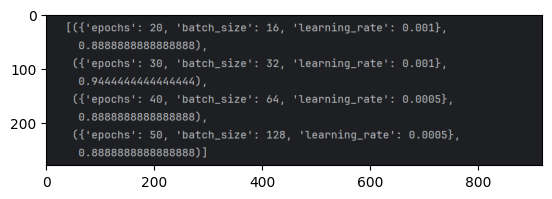

In [61]:
from PIL import Image
import matplotlib.pyplot as plt
# Display the first image
imag=Image.open('img.png')
plt.imshow(imag)
plt.show()

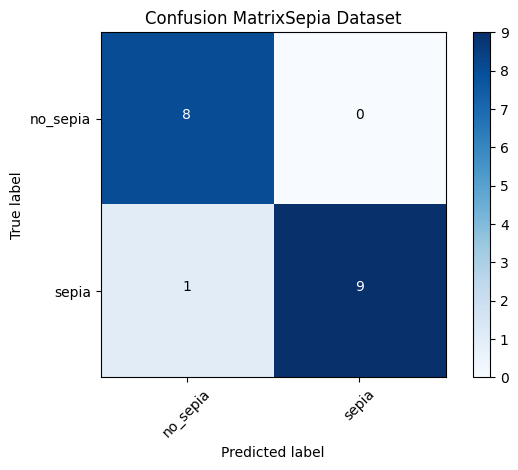

Accuracy:  0.9444444444444444
Precision:  {'no_sepia': 0.8888888888888888, 'sepia': 1.0}
Recall:  {'no_sepia': 1.0, 'sepia': 0.9}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

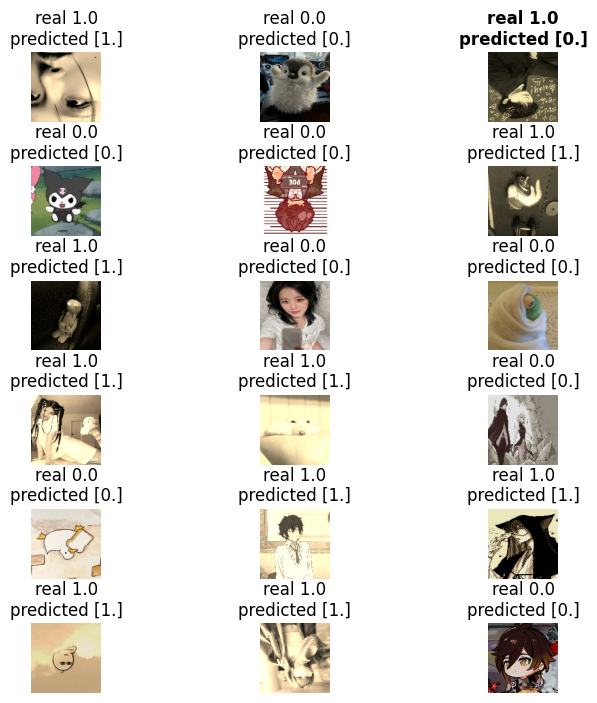

In [51]:
evaluate_model(train_inputs,train_outputs,test_inputs,test_outputs,predictedLabels)


In [52]:
%run MyANN.ipynb


In [53]:
print('With MyANN Tool')

With MyANN Tool


In [54]:
predictedLabels=with_MyAnn(train_inputs,train_outputs,test_inputs,test_outputs)

Loss at epoch 0 is 0.6915047895381142
Loss at epoch 100 is 0.5051606763416502
Loss at epoch 200 is 0.23145571560110312
Loss at epoch 300 is 0.04467335907470373
Loss at epoch 400 is 0.01958346526257375
Loss at epoch 500 is 0.011466310165315909
Loss at epoch 600 is 0.007875264402074669
Loss at epoch 700 is 0.005901366286123579
Loss at epoch 800 is 0.004663838942181757
Loss at epoch 900 is 0.0038241393987547122


In [55]:
run_myann_experiments(train_inputs, train_outputs, test_inputs, test_outputs)

Training with config: epochs=500, learning_rate=0.01, hidden_size=12
Loss at epoch 0 is 0.6928572621124357
Loss at epoch 100 is 0.5260530415718582
Loss at epoch 200 is 0.33091077627039994
Loss at epoch 300 is 0.054725952440155365
Loss at epoch 400 is 0.022879762988523615
Accuracy: 0.6666666666666666
Training with config: epochs=1000, learning_rate=0.005, hidden_size=12
Loss at epoch 0 is 0.6938839347221685
Loss at epoch 100 is 0.6458986635350284
Loss at epoch 200 is 0.3409853362866828
Loss at epoch 300 is 0.14208029307978484
Loss at epoch 400 is 0.06928869085502777
Loss at epoch 500 is 0.04004710130669893
Loss at epoch 600 is 0.026326736149745997
Loss at epoch 700 is 0.018898423712074355
Loss at epoch 800 is 0.014421770985503889
Loss at epoch 900 is 0.011503140367831146
Accuracy: 0.7222222222222222
Training with config: epochs=500, learning_rate=0.01, hidden_size=24
Loss at epoch 0 is 0.6943957869120929
Loss at epoch 100 is 0.47861609205853145
Loss at epoch 200 is 0.11966300151261994
L

[{'config': {'epochs': 500, 'learning_rate': 0.01, 'hidden_size': 12},
  'accuracy': 0.6666666666666666},
 {'config': {'epochs': 1000, 'learning_rate': 0.005, 'hidden_size': 12},
  'accuracy': 0.7222222222222222},
 {'config': {'epochs': 500, 'learning_rate': 0.01, 'hidden_size': 24},
  'accuracy': 0.7222222222222222},
 {'config': {'epochs': 1000, 'learning_rate': 0.005, 'hidden_size': 24},
  'accuracy': 0.7222222222222222},
 {'config': {'epochs': 500, 'learning_rate': 0.01, 'hidden_size': 36},
  'accuracy': 0.6666666666666666},
 {'config': {'epochs': 1000, 'learning_rate': 0.005, 'hidden_size': 36},
  'accuracy': 0.6666666666666666}]

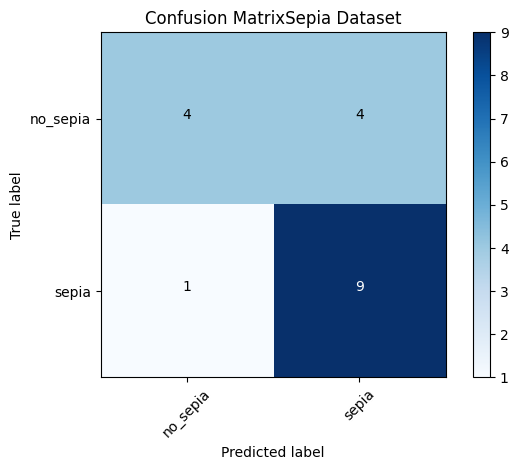

Accuracy:  0.7222222222222222
Precision:  {'no_sepia': 0.8, 'sepia': 0.6923076923076923}
Recall:  {'no_sepia': 0.5, 'sepia': 0.9}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

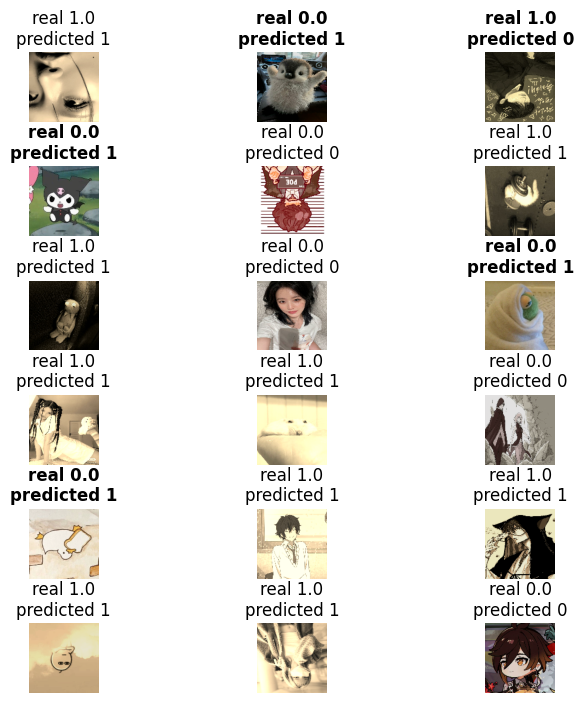

In [56]:
evaluate_model(train_inputs,train_outputs,test_inputs,test_outputs,predictedLabels)


In [26]:
%run CNN.ipynb

In [22]:
predictedLabels=with_MyCNNd(train_inputs,train_outputs,test_inputs,test_outputs)

(72, 128, 128, 3) (72,) (18, 128, 128, 3) (18,)
Epoch 1, Loss: 0.819134655821416
Gradient shapes: (31752, 1) (31752, 1) (1, 1) (1, 1)
Epoch 2, Loss: 10.277777761394775
Gradient shapes: (31752, 1) (31752, 1) (1, 1) (1, 1)
Epoch 3, Loss: 9.722222224283378
Gradient shapes: (31752, 1) (31752, 1) (1, 1) (1, 1)
Epoch 4, Loss: 10.277777761394775
Gradient shapes: (31752, 1) (31752, 1) (1, 1) (1, 1)
Epoch 5, Loss: 9.722222224283378
Gradient shapes: (31752, 1) (31752, 1) (1, 1) (1, 1)
Epoch 6, Loss: 10.277777761394775
Gradient shapes: (31752, 1) (31752, 1) (1, 1) (1, 1)
Epoch 7, Loss: 9.722222224283378
Gradient shapes: (31752, 1) (31752, 1) (1, 1) (1, 1)
Epoch 8, Loss: 10.277777761394775
Gradient shapes: (31752, 1) (31752, 1) (1, 1) (1, 1)
Epoch 9, Loss: 9.722222224283378
Gradient shapes: (31752, 1) (31752, 1) (1, 1) (1, 1)
Epoch 10, Loss: 10.277777761394775
Gradient shapes: (31752, 1) (31752, 1) (1, 1) (1, 1)


In [27]:
pr=predict(test_inputs,predictedLabels)


C:\Users\Deea\AppData\Local\Temp\ipykernel_47052\3591974311.py:7: RuntimeWarning: invalid value encountered in scalar divide
  precision[labelNames[i]]=confMatrix[i][i]/sum([confMatrix[j][i] for j in range (len(labelNames))])


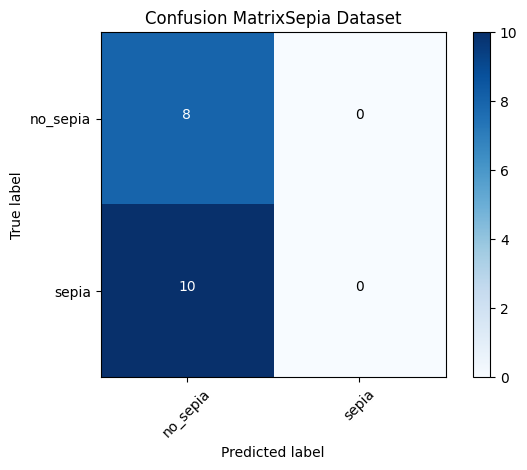

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy:  0.4444444444444444
Precision:  {'no_sepia': 0.4444444444444444, 'sepia': nan}
Recall:  {'no_sepia': 1.0, 'sepia': 0.0}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

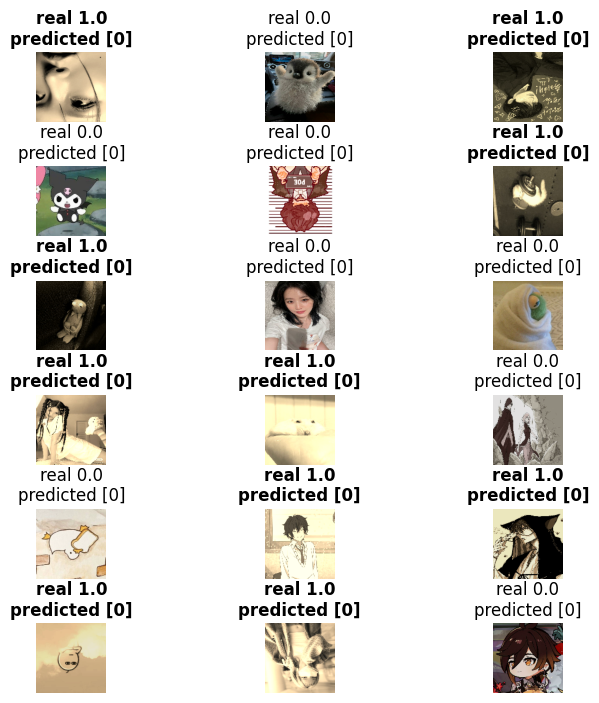

In [57]:
evaluate_model(train_inputs,train_outputs,test_inputs,test_outputs,pr)


In [ ]:
predictedLabels=with_MyCNNdo(train_inputs,train_outputs,test_inputs,test_outputs)